/tmp/ipykernel_1574437/434040876.py:242: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[INFO] Figure saved to: ./outputs/plots/instability_2x3_lr_rf_mlp_inset_percents.png | ./outputs/plots/instability_2x3_lr_rf_mlp_inset_percents.pdf | ./outputs/plots/instability_2x3_lr_rf_mlp_inset_percents.svg


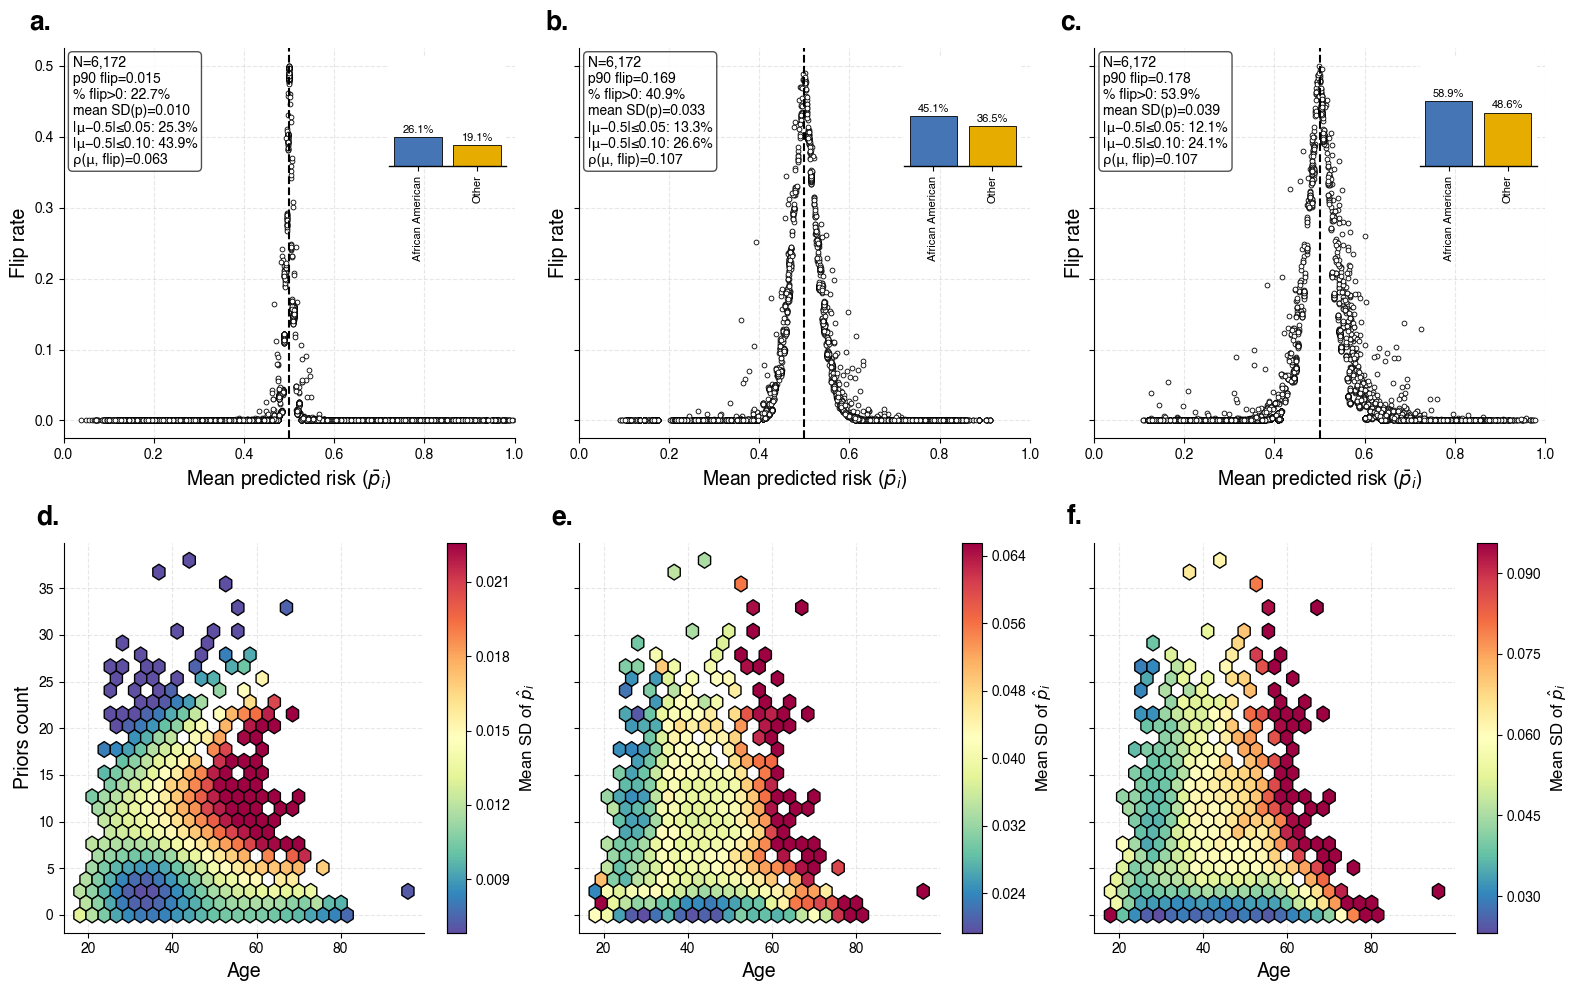

In [3]:
# === Robust plotting cell: neutral scatters + AA/non-AA inset % bars; per-panel hexbin colourbars ===
# Loads predictions from ./outputs/data; derives summaries if missing; aligns race to UID order.

import os, io, re, glob, urllib.request
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import LogLocator, MaxNLocator, FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

mpl.rcParams['font.family'] = 'Helvetica'

# ----------------------------- Paths & discovery -----------------------------
DATA_URL = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
base_dir  = "./outputs"
data_dir  = os.path.join(base_dir, "data")
plot_dir  = os.path.join(base_dir, "plots"); os.makedirs(plot_dir, exist_ok=True)

# Prefer the canonical 10000/2 file; else pick the most recent match.
default_pred = os.path.join(data_dir, "uid_oof_predictions_10000seeds_rf_lr_nn_compas_2folds.csv")
if os.path.exists(default_pred):
    pred_path = default_pred
else:
    cand = glob.glob(os.path.join(data_dir, "uid_oof_predictions_*seeds_rf_lr_nn_compas_*folds.csv"))
    if not cand:
        raise FileNotFoundError("No predictions CSV found in ./outputs/data/.")
    pred_path = max(cand, key=os.path.getmtime)

m = re.search(r"uid_oof_predictions_(\d+)seeds_rf_lr_nn_compas_(\d+)folds\.csv$", os.path.basename(pred_path))
N_SEEDS = int(m.group(1)) if m else 10000
N_SPLITS = int(m.group(2)) if m else 2
THRESH = 0.5

summary_path = os.path.join(data_dir, f"uid_summary_instability_{N_SEEDS}seeds_{N_SPLITS}folds_rf_lr_nn.csv")

# ----------------------------- Load predictions & build OOF matrices -----------------------------
df_pred = pd.read_csv(pred_path, index_col=0)
df_pred.index = df_pred.index.astype(str).str.strip()
uids = df_pred.index.to_numpy()

def extract_seednum(colname: str) -> int:
    mm = re.search(r"seed(\d+)$", colname); return int(mm.group(1)) if mm else -1

def stack_model_oof(df: pd.DataFrame, prefix: str) -> np.ndarray:
    cols = sorted([c for c in df.columns if c.startswith(prefix)], key=extract_seednum)
    if not cols:
        raise ValueError(f"No columns with prefix '{prefix}' in predictions.")
    return df[cols].to_numpy(dtype=float)

oof_lr_all = stack_model_oof(df_pred, "y_hat_lr_seed")
oof_rf_all = stack_model_oof(df_pred, "y_hat_rf_seed")
oof_nn_all = stack_model_oof(df_pred, "y_hat_nn_seed")

# ----------------------------- Per-UID stats (if summary missing, compute) -----------------------------
def per_uid_stats(oof: np.ndarray, thr: float):
    mu = np.nanmean(oof, axis=1)
    sd = np.nanstd(oof, axis=1, ddof=1)
    bin_ = (oof >= thr).astype(int)
    ones = bin_.sum(axis=1)
    flips = np.minimum(ones, oof.shape[1] - ones)
    fliprate = flips / oof.shape[1]
    return mu, sd, fliprate

if os.path.exists(summary_path):
    summary = pd.read_csv(summary_path, index_col=0)
    summary.index = summary.index.astype(str).str.strip()
    summary = summary.reindex(uids)
    age    = summary["age"].to_numpy()
    priors = summary["priors"].to_numpy()
    lr_mu, lr_sd, lr_fliprate = summary["lr_mu"].to_numpy(), summary["lr_sd"].to_numpy(), summary["lr_fliprate"].to_numpy()
    rf_mu, rf_sd, rf_fliprate = summary["rf_mu"].to_numpy(), summary["rf_sd"].to_numpy(), summary["rf_fliprate"].to_numpy()
    nn_mu, nn_sd, nn_fliprate = summary["nn_mu"].to_numpy(), summary["nn_sd"].to_numpy(), summary["nn_fliprate"].to_numpy()
else:
    lr_mu, lr_sd, lr_fliprate = per_uid_stats(oof_lr_all, THRESH)
    rf_mu, rf_sd, rf_fliprate = per_uid_stats(oof_rf_all, THRESH)
    nn_mu, nn_sd, nn_fliprate = per_uid_stats(oof_nn_all, THRESH)
    # Reload raw features to align age/priors
    with urllib.request.urlopen(DATA_URL) as resp:
        df_raw = pd.read_csv(io.BytesIO(resp.read()))
    df_raw = df_raw[
        (df_raw["days_b_screening_arrest"] <= 30) &
        (df_raw["days_b_screening_arrest"] >= -30) &
        (df_raw["is_recid"] != -1) &
        (df_raw["c_charge_degree"] != "O") &
        (df_raw["score_text"] != "N/A")
    ].copy()
    if df_raw["id"].duplicated().any():
        df_raw["id"] = df_raw["id"].astype(str) + "_" + df_raw.groupby("id").cumcount().astype(str)
    df_raw.index = df_raw["id"].astype(str).str.strip()
    age    = df_raw.reindex(uids)["age"].to_numpy()
    priors = df_raw.reindex(uids)["priors_count"].to_numpy()

# ----------------------------- Race mask aligned to UID order -----------------------------
with urllib.request.urlopen(DATA_URL) as resp:
    df_race = pd.read_csv(io.BytesIO(resp.read()))
df_race = df_race[
    (df_race["days_b_screening_arrest"] <= 30) &
    (df_race["days_b_screening_arrest"] >= -30) &
    (df_race["is_recid"] != -1) &
    (df_race["c_charge_degree"] != "O") &
    (df_race["score_text"] != "N/A")
].copy()
if df_race["id"].duplicated().any():
    df_race["id"] = df_race["id"].astype(str) + "_" + df_race.groupby("id").cumcount().astype(str)
df_race.index = df_race["id"].astype(str).str.strip()
is_black_aligned = df_race.reindex(uids)["race"].eq("African-American").fillna(False).to_numpy()

# ----------------------------- Plot configuration & helpers -----------------------------
colors = globals().get('colors', ['#4575b4',  # blue (from Spectral)
    '#E6AC00',  # gold (custom)
    '#91cf60',  # green (from Spectral)
    '#d73027',  ])  # [primary, accent, ...]

def _model_stats(mu, fliprate, sd):
    m = np.isfinite(mu) & np.isfinite(fliprate) & np.isfinite(sd)
    x, y, s = mu[m], fliprate[m], sd[m]
    near_005 = np.mean(np.abs(x - 0.5) <= 0.05)
    near_010 = np.mean(np.abs(x - 0.5) <= 0.10)
    rho = np.corrcoef(x, y)[0, 1] if x.size and y.size else np.nan
    pct_flip_pos = np.mean(y > 0.0)
    return {
        "N": int(x.size),
        "flip_p90": float(np.percentile(y, 90)),
        "sd_mean": float(np.mean(s)),
        "near_005": float(near_005),
        "near_010": float(near_010),
        "rho_mu_flip": float(rho),
        "pct_flip_pos": float(pct_flip_pos),
    }

def _fmt_stats(st):
    return (
        f"N={st['N']:,}\n"
        f"p90 flip={st['flip_p90']:.3f}\n"
        f"% flip>0: {st['pct_flip_pos']:.1%}\n"
        f"mean SD(p)={st['sd_mean']:.3f}\n"
        f"|μ−0.5|≤0.05: {st['near_005']:.1%}\n"
        f"|μ−0.5|≤0.10: {st['near_010']:.1%}\n"
        f"ρ(μ, flip)={st['rho_mu_flip']:.3f}"
    )

def _flip_counts(fliprate, race_mask):
    m = np.isfinite(fliprate)
    aa_count  = int(np.sum((fliprate[m] > 0.0) & race_mask[m]))
    non_count = int(np.sum((fliprate[m] > 0.0) & (~race_mask[m])))
    aa_total  = int(np.sum(race_mask[m]))
    non_total = int(np.sum(~race_mask[m]))
    return aa_count, non_count, aa_total, non_total

def _panel_norm(arr, lo=1.0, hi=99.0, eps=1e-8):
    a = arr[np.isfinite(arr)]
    vmin, vmax = np.percentile(a, [lo, hi]) if a.size else (eps, 1.0)
    vmin = max(float(vmin), eps)
    vmax = max(float(vmax), vmin * (1 + 1e-6))
    use_log = (vmax / vmin) > 50
    return (LogNorm(vmin=vmin, vmax=vmax) if use_log else Normalize(vmin=vmin, vmax=vmax)), use_log

# Stats for annotation + inset percentages
stats_lr, stats_rf, stats_nn = _model_stats(lr_mu, lr_fliprate, lr_sd), _model_stats(rf_mu, rf_fliprate, rf_sd), _model_stats(nn_mu, nn_fliprate, nn_sd)
lr_counts, rf_counts, nn_counts = _flip_counts(lr_fliprate, is_black_aligned), _flip_counts(rf_fliprate, is_black_aligned), _flip_counts(nn_fliprate, is_black_aligned)

# ----------------------------- Figure: 2×3 -----------------------------
fig = plt.figure(figsize=(16, 10))
gs  = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1], sharey=ax4)
ax6 = fig.add_subplot(gs[1, 2], sharey=ax4)

# Top row: neutral scatters with **inset percent bars** (AA vs non-AA)
def _scatter_plus_inset(ax, mu, fliprate, stats_text, flip_counts_tuple):
    m = np.isfinite(mu) & np.isfinite(fliprate)
    ax.scatter(mu[m], fliprate[m], s=12, alpha=1.0, facecolors='white', edgecolors='k', linewidths=0.6)
    ax.axvline(THRESH, linestyle="--", color='k')
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"Mean predicted risk ($\bar{p}_i$)", fontsize=14)
    ax.set_ylabel("Flip rate", fontsize=14)
    ax.text(0.02, 0.98, stats_text, va="top", ha="left",
            transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85, edgecolor="0.2"))

    aa_count, non_count, aa_total, non_total = flip_counts_tuple
    aa_pct  = 100.0 * aa_count  / aa_total  if aa_total  > 0 else 0.0
    non_pct = 100.0 * non_count / non_total if non_total > 0 else 0.0

    axins = inset_axes(ax, width="26%", height="28%", loc="upper right", borderpad=0.6)
    bars = axins.bar([0, 1], [aa_pct, non_pct], color=[colors[0], colors[1]], width=0.8, edgecolor='k', linewidth=0.6)
    axins.set_xticks([0, 1]); axins.set_xticklabels(["African American", "Other"], fontsize=8, rotation=90)
    axins.set_ylim(0, 100)
    axins.yaxis.set_visible(False)
    for b, val in zip(bars, [aa_pct, non_pct]):
        axins.text(b.get_x() + b.get_width()/2, b.get_height() + 2,
                   f"{val:.1f}%", ha="center", va="bottom", fontsize=8)
    # Keep only the bottom spine (opaque)
    axins.spines['left'].set_visible(False)
    axins.spines['left'].set_linewidth(0.0)
    axins.spines['right'].set_visible(False)
    axins.spines['top'].set_visible(False)
    axins.spines['bottom'].set_alpha(1.0)
    axins.spines['bottom'].set_linewidth(1.0)

_scatter_plus_inset(ax1, lr_mu, lr_fliprate, _fmt_stats(stats_lr), lr_counts)
_scatter_plus_inset(ax2, rf_mu, rf_fliprate, _fmt_stats(stats_rf), rf_counts)
_scatter_plus_inset(ax3, nn_mu, nn_fliprate, _fmt_stats(stats_nn), nn_counts)
ax2.tick_params(labelleft=False); ax3.tick_params(labelleft=False)

# Bottom row: feature-instability hexbins (SD) with per-panel colourbars
def _hex_panel(ax, x, y, z):
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    norm, is_log = _panel_norm(z[mask])
    hb = ax.hexbin(x[mask], y[mask], C=z[mask], reduce_C_function=np.mean, gridsize=27, mincnt=1,
                   norm=norm, cmap='Spectral_r', edgecolor='k')
    cbar = fig.colorbar(hb, ax=ax); cbar.set_label(r"Mean SD of $\hat{p}_i$", fontsize=12)
    if is_log: cbar.ax.yaxis.set_major_locator(LogLocator(base=10))
    else:
        cbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune="both"))
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
    return hb

_hex_panel(ax4, age, priors, lr_sd); ax4.set_xlabel("Age", fontsize=14); ax4.set_ylabel("Priors count", fontsize=14)
_hex_panel(ax5, age, priors, rf_sd); ax5.set_xlabel("Age", fontsize=14); ax5.tick_params(labelleft=False)
_hex_panel(ax6, age, priors, nn_sd); ax6.set_xlabel("Age", fontsize=14); ax6.tick_params(labelleft=False)

# Housekeeping
grid_kws = dict(which="both", linestyle='--', alpha=0.3, zorder=0)
for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.set_axisbelow(True); ax.grid(**grid_kws)

ax1.set_title('a.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')
ax2.set_title('b.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')
ax3.set_title('c.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')
ax4.set_title('d.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')
ax5.set_title('e.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')
ax6.set_title('f.', loc='left', fontsize=19, y=1.025, x=-0.075, fontweight='bold')

plt.tight_layout()
sns.despine()

out_png = os.path.join(plot_dir, "instability_2x3_lr_rf_mlp_inset_percents.png")
out_pdf = os.path.join(plot_dir, "instability_2x3_lr_rf_mlp_inset_percents.pdf")
out_svg = os.path.join(plot_dir, "instability_2x3_lr_rf_mlp_inset_percents.svg")
plt.savefig(out_png, dpi=200); plt.savefig(out_pdf); plt.savefig(out_svg)
print("[INFO] Figure saved to:", out_png, "|", out_pdf, "|", out_svg)
